In [1]:
import shapely
from shapely import Polygon

from osgeo import gdal
import rasterio

import atlite
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import xarray as xr
from scipy.constants import physical_constants

In [91]:
import cdsapi

dataset = "reanalysis-era5-single-levels"

# Request configuration
request = {
    "product_type": "reanalysis",
    "variable": [
        "evaporation",
        "potential_evaporation",
        "runoff",
        "sub_surface_runoff",
        "surface_runoff",
        "convective_precipitation",
        "total_precipitation",
    ],
    "year": ["2023"],
    "month": [
        "01", "02", "03", "04", "05", "06",
        "07", "08", "09", "10", "11", "12"
    ],
    "day": [
        "01", "02", "03", "04", "05", "06", "07", "08", "09", "10", "11", "12",
        "13", "14", "15", "16", "17", "18", "19", "20", "21", "22", "23", "24",
        "25", "26", "27", "28", "29", "30", "31"
    ],
    "time": [
        "00:00", "01:00", "02:00", "03:00", "04:00", "05:00", "06:00", "07:00",
        "08:00", "09:00", "10:00", "11:00", "12:00", "13:00", "14:00", "15:00",
        "16:00", "17:00", "18:00", "19:00", "20:00", "21:00", "22:00", "23:00"
    ],
    "format": "netcdf",
    "area": [70, -10, -35, 35],  # [North, West, South, East]
}

# Initialize CDS API client
client = cdsapi.Client()

# Retrieve and download the data
client.retrieve(dataset, request, 'era5_data.nc')


2024-12-01 18:20:19,611 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-single-levels


Exception: Not Found

In [ ]:
weather_excel_path = "Parameters/weather_parameters.xlsx"

weather_parameters = pd.read_excel(weather_excel_path,
                                       index_col = 'Parameters'
                                       ).squeeze('columns')
weather_filename = weather_parameters['Filename']

hexagons = gpd.read_file('Resources/hex_transport.geojson')

cutout = atlite.Cutout('Cutouts_23/' + weather_filename +'.nc')
cutout = atlite.Cutout('Cutouts/EU23.nc')
layout = cutout.uniform_layout()

In [60]:
# location_hydro = gpd.read_file('Data/hydropower_dams.gpkg')
location_hydro = gpd.read_file('Data/hydropower_dams_EU.gpkg')
location_hydro = location_hydro[location_hydro["country_code"] != "NO"]
location_hydro.rename(columns={'Latitude': 'lat', 'Longitude': 'lon'}, inplace=True)
location_hydro.rename(columns={'head_example':'head'},inplace=True)
location_hydro.iloc[:3]

,id,lat,lon,name,plant_type,capacity,avg_annual_generation_GWh,head,country_code,geometry
0,H1,46.073100,7.403400,Grande Dixence - Cleuson-Dixence (chandolin-fi...,HDAM,2069.0,1400.0,1748.0,CH,POINT (7.40340 46.07310)
1,H10,44.177576,7.416505,Chiotas entracque,HPHS,1064.0,NaN,130.0,IT,POINT (7.41651 44.17758)
2,H100,46.067653,10.983605,S.massenza - Vezzano molveno UP_S MASS CL_1,HPHS,377.0,NaN,580.9,IT,POINT (10.98361 46.06765)


In [61]:
hexagons['hydro'] = hexagons['hydro'].fillna(0)
hexagons['hydro'].unique()
# hex_final['capacity'] = hex_final['capacity'].fillna(0)

array([0.0000e+00, 4.3400e+00, 6.0730e+01, 8.6750e+01, 1.0410e+02,
       9.1100e+00, 2.6000e+00, 1.6660e+01, 5.9860e+01, 1.5182e+02,
       3.5569e+02, 1.3010e+01, 1.1278e+02, 1.5616e+02, 1.0800e+00,
       1.2150e+01, 1.4575e+02, 1.2580e+01, 5.7260e+01, 5.2050e+01,
       1.9950e+01, 2.7070e+01, 2.2556e+02, 1.0410e+01, 1.8218e+02,
       1.2666e+03, 4.7700e+00, 5.5520e+01, 6.9400e+00, 3.9040e+01,
       5.2100e+00, 6.1590e+01, 5.3353e+02, 8.7000e-01, 8.1900e+00,
       2.0821e+02, 4.3380e+01, 1.3187e+02, 9.3694e+02, 1.1408e+02,
       3.1230e+01, 7.6340e+01, 1.3881e+02, 1.4314e+02, 1.1451e+02,
       1.3000e+00, 2.6030e+01, 7.4610e+01, 1.4700e+00, 2.7760e+01,
       3.8170e+01, 1.3447e+02, 1.3534e+02, 2.1688e+02, 3.2530e+01,
       8.6800e+00, 4.1642e+02, 3.4700e+01, 5.6390e+02, 2.7800e+00,
       1.5620e+01])

In [63]:
# laos_hydrobasins = gpd.read_file('hydrobasins_lvl10/hybas_as_lev10_v1c.shp')
# laos_hydrobasins = gpd.read_file('hybas_as_lev12_v1c\hybas_as_lev12_v1c.shp')
laos_hydrobasins = gpd.read_file('hybas_eu_lev12_v1c\hybas_eu_lev12_v1c.shp')
# laos_hydrobasins = gpd.sjoin(laos_hydrobasins, location_hydro, how='left', predicate='intersects')

# laos_hydrobasins['lat'] = location_hydro.geometry.y
# laos_hydrobasins['lon'] = location_hydro.geometry.x
laos_hydrobasins.columns
# laos_hydrobasins.to_file('hydrobasins_lvl10/hybas_as_lev10_v1c.gpkg', driver='GPKG')

Index(['HYBAS_ID', 'NEXT_DOWN', 'NEXT_SINK', 'MAIN_BAS', 'DIST_SINK',
       'DIST_MAIN', 'SUB_AREA', 'UP_AREA', 'PFAF_ID', 'ENDO', 'COAST', 'ORDER',
       'SORT', 'geometry'],
      dtype='object')

In [64]:
plant_basin_mapping = gpd.sjoin(location_hydro, laos_hydrobasins, how='left', predicate='intersects')
print(plant_basin_mapping.isnull().sum())  # Check for plants with no matching basin

id                             0
lat                            0
lon                            0
name                           0
plant_type                     0
capacity                       0
avg_annual_generation_GWh    243
head                           0
country_code                   0
geometry                       0
index_right                    0
HYBAS_ID                       0
NEXT_DOWN                      0
NEXT_SINK                      0
MAIN_BAS                       0
DIST_SINK                      0
DIST_MAIN                      0
SUB_AREA                       0
UP_AREA                        0
PFAF_ID                        0
ENDO                           0
COAST                          0
ORDER                          0
SORT                           0
dtype: int64


In [66]:
print(location_hydro.is_valid.all())  # Should return True
laos_hydrobasins['geometry'] = laos_hydrobasins.buffer(0)
print(laos_hydrobasins.is_valid.all())  # Should return True


True
True


In [67]:
from shapely.geometry import Point

# Check if each plant intersects any basin
for plant in location_hydro.itertuples():
    point = plant.geometry
    intersecting_basins = laos_hydrobasins[laos_hydrobasins.geometry.intersects(point)]
    if intersecting_basins.empty:
        print(f"Plant at ({plant.lat}, {plant.lon}) does not intersect any basin.")


In [68]:
print("Plants (location_hydro) extent:", location_hydro.total_bounds)
print("Basins (laos_hydrobasins) extent:", laos_hydrobasins.total_bounds)


Plants (location_hydro) extent: [-8.5      36.908265 30.529583 68.10875 ]
Basins (laos_hydrobasins) extent: [-24.54232212  12.59131334  69.55451999  81.85897607]


In [69]:
hydro_profile = cutout.hydro(
    plants=location_hydro,
    hydrobasins= laos_hydrobasins,
    per_unit=True                    # Normalize output per unit area
)

Determine upstream basins per plant: 0it [00:00, ?it/s]

Determine upstream basins per plant: 536it [00:10, 51.71it/s]
c:\Users\ls2823\AppData\Local\anaconda3\envs\geoh2_master\Lib\site-packages\scipy\sparse\_base.py:730: RuntimeWarning: divide by zero encountered in divide
  recip = np.true_divide(1., other)


[########################################] | 100% Completed | 14.82 s


Shift and aggregate runoff by plant: 536it [00:18, 28.26it/s]


In [70]:
hydro_profile

<xarray.DataArray (plant: 536, time: 8784)> Size: 38MB
array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])
Coordinates:
  * plant    (plant) int64 4kB 0 1 2 3 4 5 6 7 ... 529 530 531 532 533 534 535
  * time     (time) datetime64[ns] 70kB 2023-01-01 ... 2024-01-01T23:00:00

In [71]:
def hydropower_potential(eta,flowrate,head):
    '''
    Calculate hydropower potential in Megawatts
    eta: Efficiency
    '''
    rho = 997 # kg/m3; Density of water
    g = physical_constants['standard acceleration of gravity'][0] # m/s2; Based on the CODATA constants 2018
    ###########################################################
    # Q = flowrate / 3600
    Q = (flowrate/(1000/24)) / 3600 # transform flowrate per h into flowrate per second
    return (eta * rho * g * Q * head) / (1000 * 1000) # MW


eta = 0.75 # Value for system efficiency of hydropower - source
def hydropower_potential_wrapper(flowrate, head):
    return hydropower_potential(eta, flowrate, head)

result = xr.apply_ufunc(
    hydropower_potential_wrapper,
    hydro_profile,
    xr.DataArray(location_hydro['head'], dims=['plant']),  # Ensure head values align with plant dimension
    vectorize=True
)

In [72]:

# Define the wrapper function to include capacity limiting and capacity factor calculation
def hydropower_potential_with_capacity(flowrate, head, capacity, eta):
    potential = hydropower_potential(flowrate, head, eta)
    limited_potential = xr.where(potential > capacity, capacity, potential)
    capacity_factor = limited_potential / capacity
    return capacity_factor

eta = 0.75 # efficiency of hydropower plant

capacity_factor = xr.apply_ufunc(
    hydropower_potential_with_capacity,
    hydro_profile,
    xr.DataArray(location_hydro['head'].values, dims=['plant']),
    xr.DataArray(location_hydro['capacity'].values, dims=['plant']),
    eta,
    vectorize=True,
    dask='parallelized',  # Dask for parallel computation
    output_dtypes=[float]
)

In [73]:

count_ones = (capacity_factor == 1).sum().item()
total_values = capacity_factor.size
percentage_ones = (count_ones / total_values) * 100

print(f"Total number of 1s: {count_ones}")
print(f"Percentage of 1s: {percentage_ones:.2f}%")

#v10 - 67.93%
#v12 - 67.70%

Total number of 1s: 0
Percentage of 1s: 0.00%


In [74]:
capacity_factor

<xarray.DataArray (plant: 536, time: 8784)> Size: 38MB
array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])
Coordinates:
  * plant    (plant) int64 4kB 0 1 2 3 4 5 6 7 ... 529 530 531 532 533 534 535
  * time     (time) datetime64[ns] 70kB 2023-01-01 ... 2024-01-01T23:00:00

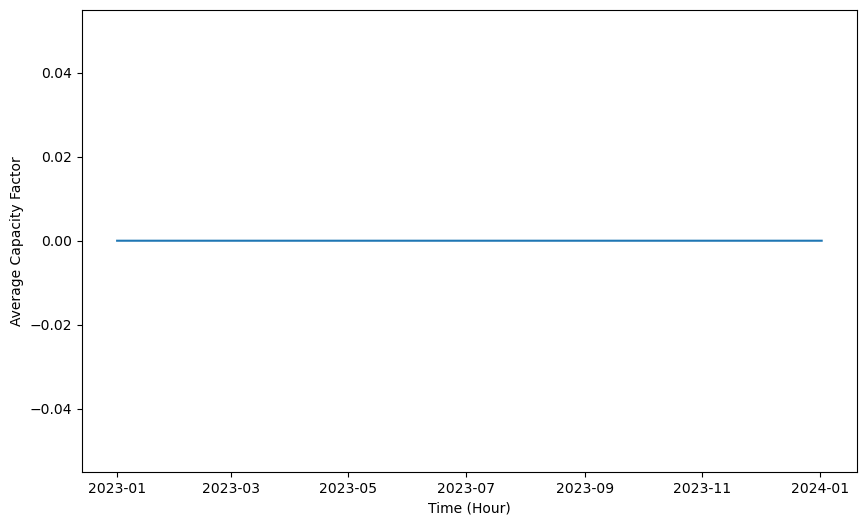

In [75]:
import matplotlib.pyplot as plt

# Calculate the average capacity factor for each hour across all plants
hourly_average = capacity_factor.mean(dim='plant')

# Plot the hourly average capacity factor over time
plt.figure(figsize=(10, 6))

# Plot the hourly average
plt.plot(hourly_average['time'], hourly_average.values)

# Add title and labels
# plt.title('Average Capacity Factor for Each Hour (All Plants)')
plt.xlabel('Time (Hour)')
plt.ylabel('Average Capacity Factor')

# Display the plot
plt.show()

# Optionally, save the plot
# plt.savefig("average_capacity_factor_per_hour.png")


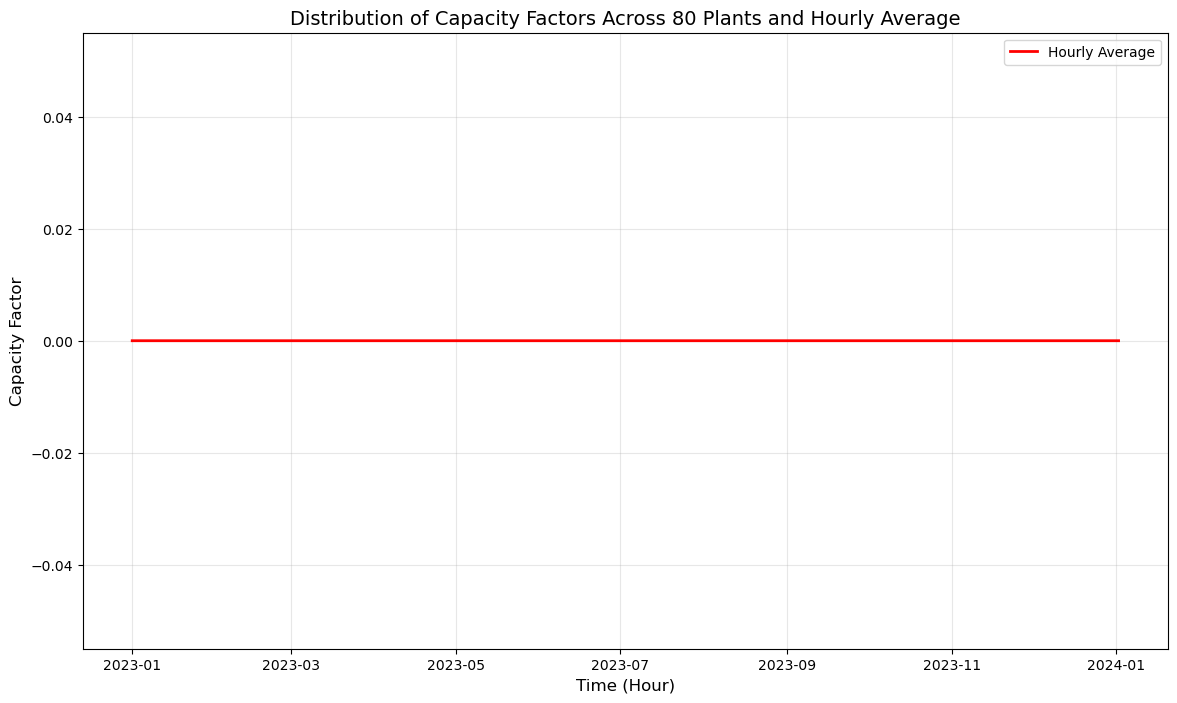

In [76]:
import matplotlib.pyplot as plt

# Calculate the average capacity factor for each hour across all plants
hourly_average = capacity_factor.mean(dim='plant')

# Set up the figure and axis
plt.figure(figsize=(14, 8))

# Plot the individual capacity factors for each plant as transparent lines
for plant in capacity_factor.plant:
    plt.plot(capacity_factor['time'], capacity_factor.sel(plant=plant), alpha=0.3, linewidth=0.5, label='_nolegend_')

# Plot the hourly average capacity factor as a bold line
plt.plot(hourly_average['time'], hourly_average.values, color='red', label='Hourly Average', linewidth=2)

# Add title, labels, and legend
plt.title('Distribution of Capacity Factors Across 80 Plants and Hourly Average', fontsize=14)
plt.xlabel('Time (Hour)', fontsize=12)
plt.ylabel('Capacity Factor', fontsize=12)
plt.legend()
plt.grid(alpha=0.3)

# Display the plot
plt.show()

# Optionally, save the plot to a file
# plt.savefig("capacity_factor_distribution.png", dpi=300)
